In [1]:
!pip install torch torchvision torchaudio transformers librosa scikit-learn tqdm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import Wav2Vec2Model, Wav2Vec2Processor, BertModel, BertTokenizer
import librosa
import numpy as np
import random
import pandas as pd
import glob
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm import tqdm

*Augmentation Functions*

In [3]:
def add_noise(audio, noise_level=0.008):
    noise = np.random.randn(len(audio))
    augmented_audio = audio + noise_level * noise
    return augmented_audio

def time_shift(audio, shift_max=0.15):
    shift = np.random.randint(int(len(audio) * shift_max))
    if np.random.rand() > 0.5:
        shift = -shift
    augmented_audio = np.roll(audio, shift)
    return augmented_audio


*Augmented Dataset Class*

In [4]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, wav2vec_processor, bert_tokenizer, max_length=128, audio_len=160000, augment=True):
        self.data = dataframe
        self.wav2vec_processor = wav2vec_processor
        self.bert_tokenizer = bert_tokenizer
        self.max_length = max_length
        self.audio_len = audio_len  # ör: 10 saniye * 16000 = 160000 örnek
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def pad_or_truncate(self, audio):
        if len(audio) < self.audio_len:
            pad_width = self.audio_len - len(audio)
            audio = np.pad(audio, (0, pad_width), mode='constant')
        else:
            audio = audio[:self.audio_len]
        return audio

    def __getitem__(self, idx):
        audio_path = self.data.iloc[idx]['audio_path']
        text_path = self.data.iloc[idx]['transcript_path']
        label = int(self.data.iloc[idx]['label'])
        #Audio
        audio, sr = librosa.load(audio_path, sr=16000)
        # Apply augmentation during training
        if self.augment:
            if random.random() < 0.5:
                audio = add_noise(audio, noise_level=0.008)
            if random.random() < 0.5:
                audio = time_shift(audio, shift_max=0.15)
        audio = self.pad_or_truncate(audio)
        audio_inputs = self.wav2vec_processor(audio, sampling_rate=16000, return_tensors="pt", padding=True)
        audio_input = audio_inputs.input_values[0]
        audio_mask = audio_inputs.attention_mask[0] if "attention_mask" in audio_inputs else torch.ones_like(audio_input)
        #Text
        with open(text_path, encoding='utf-8') as f:
            text = f.read().strip()
        text_inputs = self.bert_tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=self.max_length)
        text_input = text_inputs.input_ids[0]
        text_mask = text_inputs.attention_mask[0]

        return {
            'audio_input': audio_input,
            'audio_mask': audio_mask,
            'text_input': text_input,
            'text_mask': text_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }


*Data Preparation (DataFrame)*

In [5]:
data = []
for label, folder in [(0, "C:/Users/user/ParkinsonMultimodal/10sec_Healthy"), (1, "C:/Users/user/ParkinsonMultimodal/10sec_Parkinson")]:
    for wav_path in glob.glob(f"{folder}/*.wav"):
        txt_path = wav_path.replace('.wav', '.txt')
        data.append({
            'audio_path': wav_path,
            'transcript_path': txt_path,
            'label': label
        })
df = pd.DataFrame(data)
print(f"Total samples: {len(df)}")

Total samples: 1249


*Processor, Tokenizer, Dataset and DataLoader*

In [6]:
wav2vec_processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

dataset = MultimodalDataset(df, wav2vec_processor, bert_tokenizer, augment=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Augmentation only in training
train_dataset.dataset.augment = True
val_dataset.dataset.augment = False

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True) #shuffle=True

*Model*

In [7]:
class MultimodalFusionNet(nn.Module):
    def __init__(self, audio_model_name="facebook/wav2vec2-base-960h", text_model_name="bert-base-uncased", hidden_dim=256, num_classes=2):
        super().__init__()
        self.audio_model = Wav2Vec2Model.from_pretrained(audio_model_name)
        self.text_model = BertModel.from_pretrained(text_model_name)
        self.fusion = nn.Sequential(
            nn.Linear(self.audio_model.config.hidden_size + self.text_model.config.hidden_size, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, audio_input, audio_mask, text_input, text_mask):
        audio_feat = self.audio_model(audio_input, attention_mask=audio_mask).last_hidden_state.mean(dim=1)
        text_feat = self.text_model(input_ids=text_input, attention_mask=text_mask).last_hidden_state[:,0,:]
        fused = torch.cat([audio_feat, text_feat], dim=1)
        logits = self.fusion(fused)
        return logits


*Training Cycle + Early Stopping + Weight Decay*

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultimodalFusionNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-2)
criterion = nn.CrossEntropyLoss()

num_epochs = 30
patience = 5
best_val_loss = float('inf')
counter = 0

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        audio_input = batch['audio_input'].to(device)
        audio_mask = batch['audio_mask'].to(device)
        text_input = batch['text_input'].to(device)
        text_mask = batch['text_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(audio_input, audio_mask, text_input, text_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            audio_input = batch['audio_input'].to(device)
            audio_mask = batch['audio_mask'].to(device)
            text_input = batch['text_input'].to(device)
            text_mask = batch['text_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(audio_input, audio_mask, text_input, text_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(avg_val_loss)      
    val_accuracies.append(val_acc)       
    print(f"Epoch {epoch+1}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  0%|          | 0/63 [00:00<?, ?it/s]C:\Users\user\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
C:\Users\user\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
C:\Users\user\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.

Epoch 1, Train Loss: 0.4996
Epoch 1, Val Loss: 0.3871, Val Acc: 0.8360


100%|██████████| 63/63 [35:35<00:00, 33.90s/it]


Epoch 2, Train Loss: 0.2294
Epoch 2, Val Loss: 0.4729, Val Acc: 0.8400


100%|██████████| 63/63 [34:00<00:00, 32.39s/it]


Epoch 3, Train Loss: 0.1331
Epoch 3, Val Loss: 0.4850, Val Acc: 0.8520


100%|██████████| 63/63 [34:12<00:00, 32.58s/it]


Epoch 4, Train Loss: 0.0943
Epoch 4, Val Loss: 0.4214, Val Acc: 0.8720


100%|██████████| 63/63 [33:41<00:00, 32.09s/it]


Epoch 5, Train Loss: 0.0155
Epoch 5, Val Loss: 0.7875, Val Acc: 0.8240


100%|██████████| 63/63 [33:27<00:00, 31.86s/it]


Epoch 6, Train Loss: 0.0228
Epoch 6, Val Loss: 0.5377, Val Acc: 0.8440
Early stopping at epoch 6


*Loss and Accuracy Graphs*

In [9]:
print(f"Train set size: {len(train_dataset)}")
print(f"Val set size: {len(val_dataset)}")

Train set size: 999
Val set size: 250


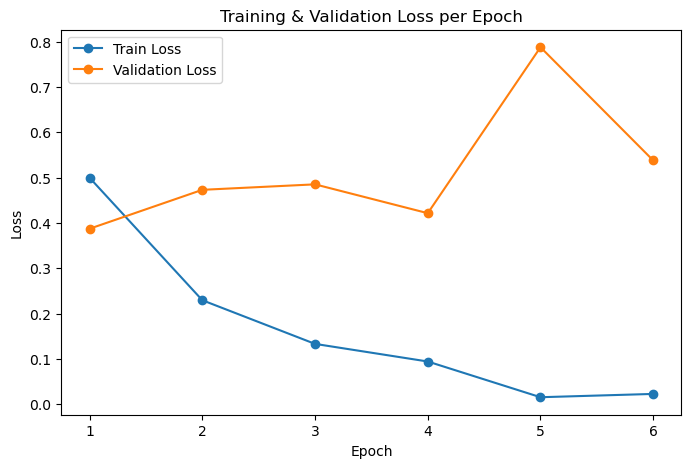

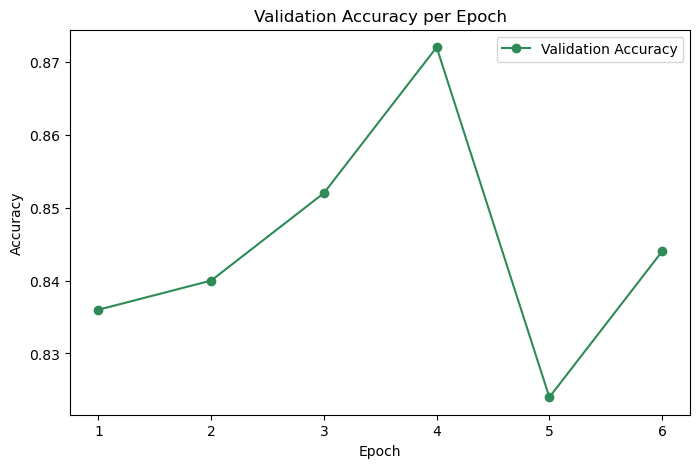

In [10]:
epochs = range(1, len(train_losses)+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss per Epoch')
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, val_accuracies, label='Validation Accuracy', marker='o', color='seagreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.show()


*Result Analysis*

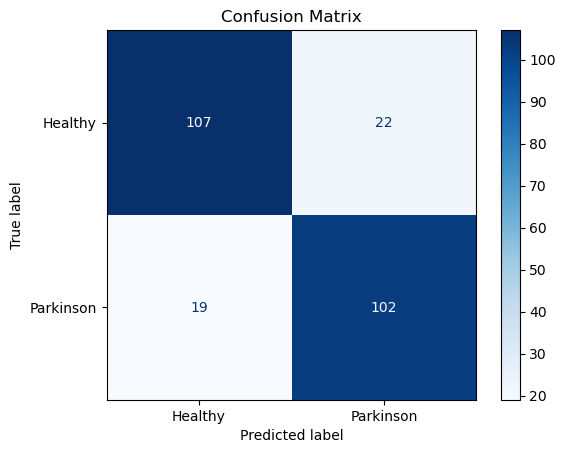

In [11]:
# Load the best model
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

all_preds = []
all_labels = []
all_probs = []
with torch.no_grad():
    for batch in val_loader:
        audio_input = batch['audio_input'].to(device)
        audio_mask = batch['audio_mask'].to(device)
        text_input = batch['text_input'].to(device)
        text_mask = batch['text_mask'].to(device)
        labels = batch['labels'].cpu().numpy()
        outputs = model(audio_input, audio_mask, text_input, text_mask)
        probs = torch.softmax(outputs, dim=1)[:,1].cpu().numpy()
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels)
        all_probs.extend(probs)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Healthy", "Parkinson"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [12]:
# Classification report
print(classification_report(all_labels, all_preds, target_names=["Healthy", "Parkinson"]))
report = classification_report(all_labels, all_preds, target_names=["Healthy", "Parkinson"], output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report.style.background_gradient(axis=1, cmap='Blues').format("{:.2f}"))


              precision    recall  f1-score   support

     Healthy       0.85      0.83      0.84       129
   Parkinson       0.82      0.84      0.83       121

    accuracy                           0.84       250
   macro avg       0.84      0.84      0.84       250
weighted avg       0.84      0.84      0.84       250



,precision,recall,f1-score,support
Healthy,0.85,0.83,0.84,129.00
Parkinson,0.82,0.84,0.83,121.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.84,0.84,0.84,250.00
weighted avg,0.84,0.84,0.84,250.00


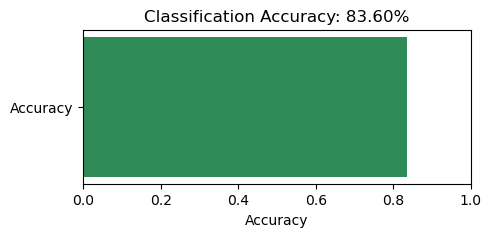

In [13]:
# Accuracy bar
acc = accuracy_score(all_labels, all_preds)
plt.figure(figsize=(5,2))
plt.barh(['Accuracy'], [acc], color='seagreen')
plt.xlim(0, 1)
plt.xlabel("Accuracy")
plt.title(f"Classification Accuracy: {acc:.2%}")
plt.show()

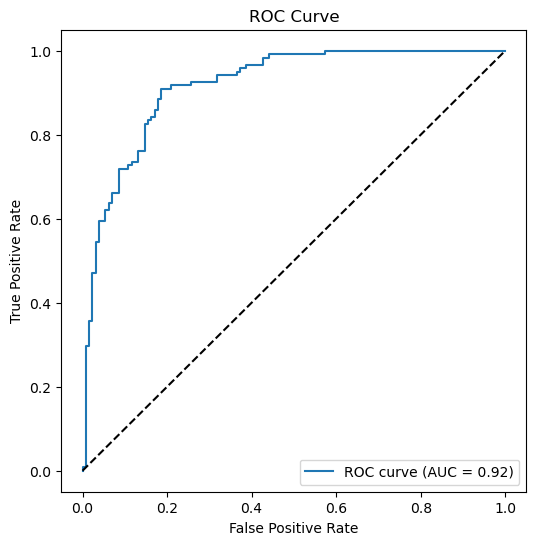

In [14]:
# ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()